This notebook is for performing transfer learning

In [1]:
import input_util as ip
import transfer_models as mdl
import torch
import torch.optim as optim
import torch.nn as nn

# preliminaries:
input_size = 224 # for RESNET
model_name = 'resnet'
num_output = 14 
feature_extract = True

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Preprocess the Data

In [2]:
subject_list = {}
subject_list['KT'] = [['B','C','D','E','F','G','H','I'],[[0,1,2,3],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[2,3,4],[0,1,2,4]]]
#subject_list['KT'] = [['B'],[4]]

task = 'KT'
act = 'Knot_Tying'
subj = subject_list[task][0]
trial = subject_list[task][1]

y, index_dict = ip.collect_labels(act,task,subj,trial)


reading Knot_Tying/video/Knot_Tying_B001_capture1.avi
total frame count : 1750
total labels loaded: 1735
(1735, 14)
1735
reading Knot_Tying/video/Knot_Tying_B002_capture1.avi
total frame count : 1486
total labels loaded: 1480
(1480, 14)
1480
reading Knot_Tying/video/Knot_Tying_B003_capture1.avi
total frame count : 1615
total labels loaded: 1612
(1612, 14)
1612
reading Knot_Tying/video/Knot_Tying_B004_capture1.avi
total frame count : 1826
total labels loaded: 1820
(1820, 14)
1820
reading Knot_Tying/video/Knot_Tying_C001_capture1.avi
total frame count : 1234
total labels loaded: 1227
(1227, 14)
1227
reading Knot_Tying/video/Knot_Tying_C002_capture1.avi
total frame count : 1074
total labels loaded: 1068
(1068, 14)
1068
reading Knot_Tying/video/Knot_Tying_C003_capture1.avi
total frame count : 1079
total labels loaded: 1073
(1073, 14)
1073
reading Knot_Tying/video/Knot_Tying_C004_capture1.avi
total frame count : 1398
total labels loaded: 1383
(1383, 14)
1383
reading Knot_Tying/video/Knot_Ty

# Load the Data

In [2]:
import pickle

f = open("index_dict.dat",'rb')
index_dict = pickle.load(f)
f.close()

train_loader,val_loader,seq_loader = ip.load_dataset(input_size,index_dict,num_train_trials=30,num_val_trials=5)

dataloaders_dict = {}
dataloaders_dict['train']= train_loader
dataloaders_dict['val'] = val_loader



num image files: 61614
shape of label data: 61614x14


# Initialize the Model

In [3]:
model_ft, input_size = mdl.initialize_model(model_name, num_output, feature_extract, use_pretrained=True)
print(model_ft)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('using device:')
print(device)

# Send the model to GPU
model_ft = model_ft.to(device)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(6

# Define Optimizer

In [6]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Setup the loss fxn
criterion = nn.MSELoss(reduction='mean')


Params to learn:
	 0.fc.weight
	 0.fc.bias
	 1.weight
	 1.bias
	 3.weight
	 3.bias
	 4.weight
	 4.bias
	 6.weight
	 6.bias
	 7.weight
	 7.bias
	 9.weight
	 9.bias


# Training Phase

In [ ]:
num_epochs = 1

# Train and evaluate
model_ft, hist = mdl.train_model(model_ft, dataloaders_dict, device, criterion, optimizer_ft, num_epochs=num_epochs,print_every = 5 , is_inception=(model_name=="inception"))

Epoch 0/0
----------
loss for iteration 5: 0.718042


# Save the model (don't do this unless you are sure!)

In [ ]:
f = open("model_weights.model",'wb')
torch.save(model_ft.state_dict(), f)
f.close()

# Visualize Results

Checking accuracy on sequential validation set
saving our results...
MSE loss is: 0.007816 


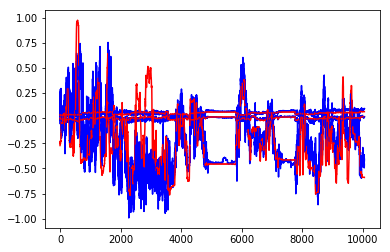

In [4]:
f = open("model_weights.model",'rb')
model_ft.load_state_dict(torch.load(f))
f.close()

import vis_util as vis

vis.check_accuracy_vis(seq_loader,model_ft,device)